# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


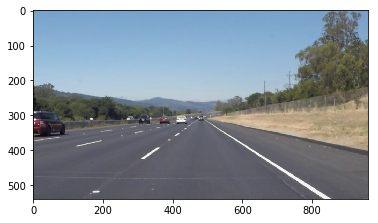

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [99]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def filter_avg_slopes(lineparameters):
    """
    This function is going to filter out outliers and average the remaining slope lines
    lineparameters are the slopes and intercepts of the lines. Based on suggestions in
    the online forum, this function will filter out slopes which are 1 standard deviation
    from the mean
    """
    slopesArray = [lineparameter[0] for lineparameter in lineparameters]
    interceptsArray = [lineparameter[1] for lineparameter in lineparameters]
    aveSlope = np.mean(slopesArray)
    sdSlope = np.std(slopesArray)
    
    #create an Array for storing the filtered slopes and one for filtered intercepts
    filtered_slopes =[]
    filtered_intercepts =[]
    
    for lineparameter in lineparameters:
        #filter out noise, only keep lines with 1 standard deviation
        if abs(lineparameter[0] - aveSlope) < sdSlope:
            filtered_slopes.append(lineparameter[0])
            filtered_intercepts.append(lineparameter[1])
    
    if not filtered_slopes: #if everything was an outlier just return what we have
        filtered_slopes = slopesArray
        filtered_intercepts = interceptsArray
        
    return np.mean(filtered_slopes),np.mean(filtered_intercepts)
        
        
def extrapolate_line(img,intersectionPoint, slope, intercept):
    #extrapolate by getting line coordinates from the point of intersection of the two lines
    # to the end of the image
    intersectionCoords = (int(intersectionPoint),int((intersectionPoint*slope)+intercept))
    imshape = img.shape
    if slope >0:
            edgePoint = (int(imshape[1]),int((imshape[1]*slope)+intercept) )
    elif slope <0:
            edgePoint = (0,int(intercept) )
    
    return (intersectionCoords,edgePoint)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #get the image shape
    imshape = img.shape
    
    #lets get the slopes and intercepts for the lines in parameter space
    #lines on the right should have positive slopes
    #lines on the left should have negative slopes
    
    
    right_line = [] # array for the slope and intercept of the line
    
    left_line = [] # array for the slope and intercept of the left lines
    
    #the input "lines" is an array of the line coordinates
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2)/(x1 -x2)
            len = math.hypot(x2-x1,y2-y1)
            
            if not math.isnan(slope):
                if slope > 0:                                       
                    #calculate the intercept and store it along with slope, use "y-mx" to get intercept
                    right_line.append([slope,(y1 - slope*x1)])
                elif slope < 0:                    
                    #calculate the intercept and store it along with slope, use "y-mx" to get intercept
                    left_line.append([slope,(y1 - slope*x1)])
                    
  
    
    #filter and average the slope for the right and left lanes
    rightSlope,rightIntercept = filter_avg_slopes(right_line)
    leftSlope,leftIntercept = filter_avg_slopes(left_line)
            
    #we know want to extrapolate this line using the parameters we calculated
    #We can calculate the intersection point of these two lines, and draw the
    #line from the bottom part of the image to the intersection point
    
    #calculate the intersection point of the two lines- we can do this by 
    # solving for the x-coordinate "intercept2 - intercept1"/slope1 - slope2
    
    xIntersection = (leftIntercept - rightIntercept)/(rightSlope - leftSlope)
    
    #get the extrapolated lines
    rightLinePoint1,rightLinePoint2 = extrapolate_line(img,xIntersection, rightSlope, rightIntercept)
    leftLinePoint1,leftLinePoint2 = extrapolate_line(img,xIntersection, leftSlope, leftIntercept)
    
    #now draw these line
    cv2.line(img, rightLinePoint1, rightLinePoint2, color, thickness)
    cv2.line(img, leftLinePoint1, leftLinePoint2, color, thickness)
            
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [101]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def draw_lines_pipeline(image):

    #first step of the pipeline, covert to grayscale
    imshape = image.shape
    gsImage = grayscale(image)
    plt.subplot(3,3,1)
    plt.imshow(gsImage, cmap="gray")
    
    #next step of the pipeline, perfrom gaussian blur
    
    kernel_size = 5
    gsImageBlur = gaussian_blur(gsImage,kernel_size)
    plt.subplot(3,3,2)
    plt.imshow(gsImageBlur)
    
    #next step, perfrom canny edge detection
    low_threshold = 50
    high_threshold = 150
    
    cannyEdges = canny(gsImageBlur,low_threshold,high_threshold)
    plt.subplot(3,3,3)
    plt.imshow(cannyEdges)
    
    #next step , get the region of interest
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]],dtype=np.int32)
    roi = region_of_interest(cannyEdges, vertices)
    plt.subplot(3,3,4)
    plt.imshow(roi)
    
    #next step in the pipeline , get the hough lines
    # Hough lines
  
    line_image = np.copy(image)*0
   # HoughLines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    HoughLines = hough_lines(roi, 1, np.pi/180, 35, 5, 2)
    print("shape of hough transformed image",HoughLines.shape)
    
    #convert image to RGB otherwise the final image is gray
    HoughLinesRGB = cv2.cvtColor(HoughLines, cv2.COLOR_GRAY2RGB)
   
    
    plt.subplot(3,3,5)
    plt.imshow(HoughLinesRGB)
    
    
    # Combine lines image with original image
    final_image = weighted_img(HoughLinesRGB, image)
    ## Plot final image
    plt.subplot(3,3,6)
    plt.imshow(final_image,cmap = 'gray')
    return final_image
    
    
    

In [10]:
test_images = [mpimg.imread('test_images/' + i) for i in os.listdir('test_images/')]

shape of hough transformed image (540, 960)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

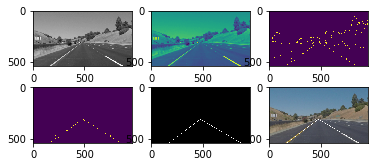

In [102]:
draw_lines_pipeline(test_images[0])

shape of hough transformed image (540, 960)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

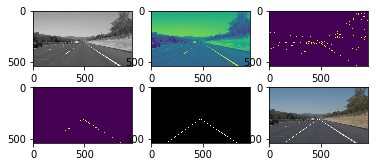

In [90]:
draw_lines_pipeline(test_images[1])

shape of hough transformed image (540, 960)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

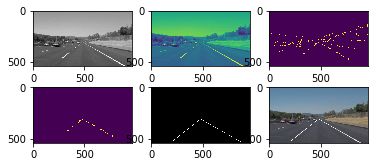

In [91]:
draw_lines_pipeline(test_images[2])

shape of hough transformed image (540, 960)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

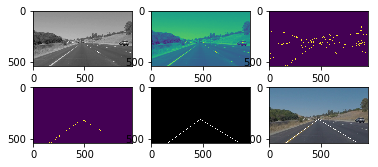

In [92]:
draw_lines_pipeline(test_images[3])

shape of hough transformed image (540, 960)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

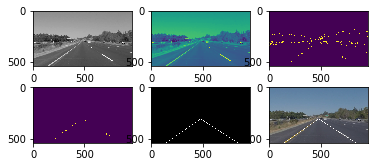

In [93]:
draw_lines_pipeline(test_images[4])

shape of hough transformed image (540, 960)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

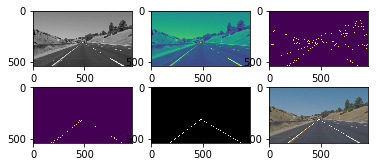

In [94]:
draw_lines_pipeline(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_lines_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

shape of hough transformed image (540, 960)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

shape of hough transformed image (540, 960)


  0%|          | 1/222 [00:00<00:25,  8.77it/s]

shape of hough transformed image (540, 960)


  1%|▏         | 3/222 [00:00<00:26,  8.23it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 4/222 [00:00<00:27,  8.04it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  3%|▎         | 6/222 [00:00<00:26,  8.10it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 7/222 [00:00<00:26,  8.01it/s]

shape of hough transformed image (540, 960)


  4%|▎         | 8/222 [00:00<00:26,  8.22it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  4%|▍         | 9/222 [00:01<00:26,  8.04it/s]

shape of hough transformed image (540, 960)


  5%|▍         | 10/222 [00:01<00:26,  7.90it/s]

shape of hough transformed image (540, 960)


  5%|▌         | 12/222 [00:01<00:26,  8.00it/s]

shape of hough transformed image (540, 960)


  6%|▌         | 13/222 [00:01<00:25,  8.14it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  6%|▋         | 14/222 [00:01<00:26,  7.90it/s]

shape of hough transformed image (540, 960)


  7%|▋         | 15/222 [00:01<00:26,  7.82it/s]

shape of hough transformed image (540, 960)


  7%|▋         | 16/222 [00:02<00:26,  7.84it/s]

shape of hough transformed image (540, 960)


  8%|▊         | 17/222 [00:02<00:26,  7.61it/s]

shape of hough transformed image (540, 960)


  8%|▊         | 18/222 [00:02<00:26,  7.57it/s]

shape of hough transformed image (540, 960)


  9%|▊         | 19/222 [00:02<00:27,  7.47it/s]

shape of hough transformed image (540, 960)


  9%|▉         | 20/222 [00:02<00:26,  7.52it/s]

shape of hough transformed image (540, 960)


  9%|▉         | 21/222 [00:02<00:26,  7.71it/s]

shape of hough transformed image (540, 960)


 10%|▉         | 22/222 [00:02<00:26,  7.56it/s]

shape of hough transformed image (540, 960)


 10%|█         | 23/222 [00:02<00:26,  7.43it/s]

shape of hough transformed image (540, 960)


 11%|█         | 24/222 [00:03<00:25,  7.73it/s]

shape of hough transformed image (540, 960)


 11%|█▏        | 25/222 [00:03<00:25,  7.66it/s]

shape of hough transformed image (540, 960)


 12%|█▏        | 26/222 [00:03<00:26,  7.52it/s]

shape of hough transformed image (540, 960)


 12%|█▏        | 27/222 [00:03<00:25,  7.79it/s]

shape of hough transformed image (540, 960)


 13%|█▎        | 28/222 [00:03<00:25,  7.71it/s]

shape of hough transformed image (540, 960)


 13%|█▎        | 29/222 [00:03<00:26,  7.37it/s]

shape of hough transformed image (540, 960)


 14%|█▎        | 30/222 [00:03<00:25,  7.51it/s]

shape of hough transformed image (540, 960)


 14%|█▍        | 31/222 [00:04<00:25,  7.53it/s]

shape of hough transformed image (540, 960)


 14%|█▍        | 32/222 [00:04<00:25,  7.52it/s]

shape of hough transformed image (540, 960)


 15%|█▍        | 33/222 [00:04<00:24,  7.78it/s]

shape of hough transformed image (540, 960)


 15%|█▌        | 34/222 [00:04<00:24,  7.64it/s]

shape of hough transformed image (540, 960)


 16%|█▌        | 35/222 [00:04<00:23,  7.79it/s]

shape of hough transformed image (540, 960)


 16%|█▌        | 36/222 [00:04<00:24,  7.46it/s]

shape of hough transformed image (540, 960)


 17%|█▋        | 38/222 [00:04<00:23,  7.68it/s]

shape of hough transformed image (540, 960)


 18%|█▊        | 39/222 [00:05<00:22,  8.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 18%|█▊        | 40/222 [00:05<00:23,  7.80it/s]

shape of hough transformed image (540, 960)


 18%|█▊        | 41/222 [00:05<00:23,  7.70it/s]

shape of hough transformed image (540, 960)


 19%|█▉        | 42/222 [00:05<00:23,  7.61it/s]

shape of hough transformed image (540, 960)


 20%|█▉        | 44/222 [00:05<00:30,  5.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 21%|██        | 46/222 [00:06<00:33,  5.22it/s]

shape of hough transformed image (540, 960)


 21%|██        | 47/222 [00:06<00:33,  5.25it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 23%|██▎       | 50/222 [00:06<00:29,  5.86it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 23%|██▎       | 51/222 [00:07<00:30,  5.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 24%|██▍       | 53/222 [00:07<00:30,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 25%|██▍       | 55/222 [00:07<00:29,  5.57it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 26%|██▌       | 57/222 [00:08<00:30,  5.45it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 27%|██▋       | 59/222 [00:08<00:28,  5.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 27%|██▋       | 61/222 [00:08<00:28,  5.70it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 28%|██▊       | 63/222 [00:09<00:27,  5.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 29%|██▉       | 65/222 [00:09<00:26,  5.86it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 30%|███       | 67/222 [00:09<00:26,  5.92it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 31%|███       | 69/222 [00:10<00:28,  5.45it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 32%|███▏      | 71/222 [00:10<00:26,  5.74it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 33%|███▎      | 73/222 [00:11<00:29,  5.04it/s]

shape of hough transformed image (540, 960)


 33%|███▎      | 74/222 [00:11<00:29,  5.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 34%|███▍      | 75/222 [00:11<00:29,  4.93it/s]

 (540, 960)


 34%|███▍      | 76/222 [00:11<00:28,  5.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 35%|███▌      | 78/222 [00:12<00:29,  4.84it/s]

shape of hough transformed image (540, 960)


 36%|███▌      | 79/222 [00:12<00:28,  4.97it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 36%|███▋      | 81/222 [00:12<00:28,  5.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 37%|███▋      | 83/222 [00:13<00:26,  5.15it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 38%|███▊      | 85/222 [00:13<00:25,  5.32it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 39%|███▉      | 87/222 [00:13<00:24,  5.48it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 40%|████      | 89/222 [00:14<00:24,  5.53it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 41%|████      | 91/222 [00:14<00:24,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 42%|████▏     | 93/222 [00:14<00:23,  5.56it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image 

 42%|████▏     | 94/222 [00:15<00:22,  5.60it/s]

(540, 960)
shape of hough transformed image (540, 960)


 43%|████▎     | 96/222 [00:15<00:22,  5.67it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 44%|████▍     | 98/222 [00:15<00:21,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 45%|████▌     | 100/222 [00:16<00:21,  5.73it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 46%|████▌     | 102/222 [00:16<00:20,  5.74it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 47%|████▋     | 104/222 [00:16<00:20,  5.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 48%|████▊     | 106/222 [00:17<00:20,  5.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 49%|████▊     | 108/222 [00:17<00:20,  5.62it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 50%|████▉     | 110/222 [00:17<00:19,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 50%|█████     | 112/222 [00:18<00:19,  5.63it/s]

shape of hough transformed image (540, 960)


 51%|█████     | 113/222 [00:18<00:19,  5.63it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 52%|█████▏    | 115/222 [00:18<00:18,  5.66it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 53%|█████▎    | 117/222 [00:19<00:19,  5.42it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 54%|█████▎    | 119/222 [00:19<00:19,  5.18it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▍    | 121/222 [00:20<00:19,  5.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▌    | 123/222 [00:20<00:18,  5.22it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 56%|█████▋    | 125/222 [00:20<00:16,  5.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 57%|█████▋    | 127/222 [00:21<00:15,  5.97it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 59%|█████▊    | 130/222 [00:21<00:14,  6.19it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 59%|█████▉    | 131/222 [00:21<00:15,  6.07it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 60%|█████▉    | 133/222 [00:22<00:14,  5.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 61%|██████    | 135/222 [00:22<00:15,  5.76it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 62%|██████▏   | 137/222 [00:22<00:14,  6.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 63%|██████▎   | 139/222 [00:23<00:15,  5.41it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 63%|██████▎   | 140/222 [00:23<00:15,  5.23it/s]

 (540, 960)


 64%|██████▎   | 141/222 [00:23<00:16,  5.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 64%|██████▍   | 143/222 [00:23<00:14,  5.27it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 65%|██████▌   | 145/222 [00:24<00:14,  5.44it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 66%|██████▌   | 147/222 [00:24<00:13,  5.58it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 67%|██████▋   | 149/222 [00:25<00:12,  5.63it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 68%|██████▊   | 151/222 [00:25<00:13,  5.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 69%|██████▉   | 153/222 [00:25<00:12,  5.71it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 70%|██████▉   | 155/222 [00:26<00:11,  5.96it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 71%|███████   | 157/222 [00:26<00:11,  5.88it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 72%|███████▏  | 159/222 [00:26<00:10,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 73%|███████▎  | 161/222 [00:27<00:09,  6.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 73%|███████▎  | 163/222 [00:27<00:10,  5.50it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 75%|███████▍  | 166/222 [00:27<00:08,  6.31it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 75%|███████▌  | 167/222 [00:28<00:08,  6.39it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 76%|███████▌  | 169/222 [00:28<00:09,  5.59it/s]

shape of hough transformed image (540, 960)


 77%|███████▋  | 170/222 [00:28<00:09,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 77%|███████▋  | 172/222 [00:29<00:08,  5.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 78%|███████▊  | 174/222 [00:29<00:08,  5.73it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 79%|███████▉  | 176/222 [00:29<00:07,  5.96it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 80%|████████  | 178/222 [00:30<00:07,  6.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 82%|████████▏ | 181/222 [00:30<00:06,  6.14it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 82%|████████▏ | 182/222 [00:30<00:06,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 83%|████████▎ | 184/222 [00:31<00:06,  5.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 84%|████████▍ | 186/222 [00:31<00:06,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 85%|████████▌ | 189/222 [00:31<00:04,  6.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 86%|████████▌ | 190/222 [00:32<00:05,  6.17it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 86%|████████▋ | 192/222 [00:32<00:04,  6.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 87%|████████▋ | 194/222 [00:32<00:04,  6.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 88%|████████▊ | 196/222 [00:33<00:03,  6.59it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 90%|████████▉ | 199/222 [00:33<00:03,  6.92it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 90%|█████████ | 200/222 [00:33<00:03,  6.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 91%|█████████ | 201/222 [00:33<00:03,  6.10it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 91%|█████████▏| 203/222 [00:34<00:03,  5.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 92%|█████████▏| 205/222 [00:34<00:02,  5.80it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 94%|█████████▎| 208/222 [00:34<00:02,  6.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 94%|█████████▍| 209/222 [00:35<00:02,  6.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 95%|█████████▌| 212/222 [00:35<00:01,  6.26it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 96%|█████████▌| 213/222 [00:35<00:01,  6.15it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 97%|█████████▋| 215/222 [00:36<00:01,  5.59it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 98%|█████████▊| 217/222 [00:36<00:00,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 99%|█████████▊| 219/222 [00:36<00:00,  5.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


100%|█████████▉| 221/222 [00:37<00:00,  5.91it/s]


shape of hough transformed image (540, 960)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.7 s, sys: 412 ms, total: 11.2 s
Wall time: 38.9 s


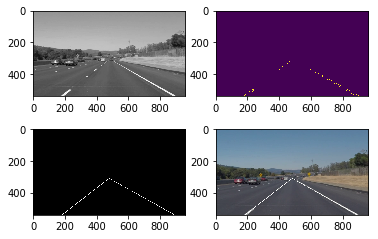

In [45]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

shape of hough transformed image (540, 960)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

shape of hough transformed image (540, 960)


  0%|          | 1/682 [00:00<01:16,  8.89it/s]

shape of hough transformed image (540, 960)


  0%|          | 2/682 [00:00<01:24,  8.01it/s]

shape of hough transformed image (540, 960)


  0%|          | 3/682 [00:00<01:23,  8.12it/s]

shape of hough transformed image (540, 960)


  1%|          | 4/682 [00:00<01:26,  7.83it/s]

shape of hough transformed image (540, 960)


  1%|          | 6/682 [00:00<01:23,  8.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  1%|          | 7/682 [00:00<01:25,  7.93it/s]

shape of hough transformed image (540, 960)


  1%|          | 8/682 [00:01<01:23,  8.07it/s]

shape of hough transformed image (540, 960)


  1%|▏         | 9/682 [00:01<01:25,  7.89it/s]

shape of hough transformed image (540, 960)


  1%|▏         | 10/682 [00:01<01:27,  7.70it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 11/682 [00:01<01:24,  7.95it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 13/682 [00:01<01:26,  7.78it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 14/682 [00:01<01:23,  7.99it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 15/682 [00:01<01:25,  7.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  2%|▏         | 16/682 [00:02<01:24,  7.85it/s]

shape of hough transformed image (540, 960)


  2%|▏         | 17/682 [00:02<01:27,  7.60it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 18/682 [00:02<01:28,  7.54it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 19/682 [00:02<01:25,  7.78it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 20/682 [00:02<01:26,  7.64it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 21/682 [00:02<01:25,  7.73it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 22/682 [00:02<01:25,  7.72it/s]

shape of hough transformed image (540, 960)


  3%|▎         | 23/682 [00:02<01:26,  7.61it/s]

shape of hough transformed image (540, 960)


  4%|▎         | 24/682 [00:03<01:24,  7.80it/s]

shape of hough transformed image (540, 960)


  4%|▎         | 25/682 [00:03<01:26,  7.59it/s]

shape of hough transformed image (540, 960)


  4%|▍         | 26/682 [00:03<01:25,  7.64it/s]

shape of hough transformed image (540, 960)


  4%|▍         | 27/682 [00:03<01:27,  7.51it/s]

shape of hough transformed image (540, 960)


  4%|▍         | 28/682 [00:03<01:28,  7.43it/s]

shape of hough transformed image (540, 960)


  4%|▍         | 29/682 [00:03<01:24,  7.71it/s]

shape of hough transformed image (540, 960)


  5%|▍         | 31/682 [00:04<01:25,  7.65it/s]

shape of hough transformed image (540, 960)


  5%|▍         | 32/682 [00:04<01:22,  7.90it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  5%|▍         | 33/682 [00:04<01:23,  7.78it/s]

shape of hough transformed image (540, 960)


  5%|▍         | 34/682 [00:04<01:24,  7.68it/s]

shape of hough transformed image (540, 960)


  5%|▌         | 36/682 [00:04<01:22,  7.83it/s]

shape of hough transformed image (540, 960)


  5%|▌         | 37/682 [00:04<01:19,  8.08it/s]

shape of hough transformed image (540, 960)


  6%|▌         | 38/682 [00:04<01:20,  7.97it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  6%|▌         | 39/682 [00:05<01:21,  7.90it/s]

shape of hough transformed image (540, 960)


  6%|▌         | 40/682 [00:05<01:20,  7.98it/s]

shape of hough transformed image (540, 960)


  6%|▌         | 41/682 [00:05<01:23,  7.70it/s]

shape of hough transformed image (540, 960)


  6%|▌         | 42/682 [00:05<01:25,  7.52it/s]

shape of hough transformed image (540, 960)


  6%|▋         | 44/682 [00:05<01:51,  5.71it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  7%|▋         | 46/682 [00:06<01:59,  5.32it/s]

shape of hough transformed image (540, 960)


  7%|▋         | 47/682 [00:06<01:57,  5.42it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  7%|▋         | 49/682 [00:06<01:55,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  7%|▋         | 51/682 [00:07<01:55,  5.47it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  8%|▊         | 53/682 [00:07<01:50,  5.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  8%|▊         | 55/682 [00:07<01:47,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  8%|▊         | 57/682 [00:08<01:46,  5.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  9%|▊         | 59/682 [00:08<01:51,  5.58it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  9%|▉         | 61/682 [00:08<01:49,  5.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


  9%|▉         | 63/682 [00:09<01:55,  5.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 10%|▉         | 65/682 [00:09<01:54,  5.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 10%|▉         | 67/682 [00:10<01:55,  5.32it/s]

shape of hough transformed image (540, 960)


 10%|▉         | 68/682 [00:10<02:02,  5.00it/s]

shape of hough transformed image (540, 960)


 10%|█         | 69/682 [00:10<02:22,  4.31it/s]

shape of hough transformed image (540, 960)


 10%|█         | 70/682 [00:10<02:09,  4.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 11%|█         | 72/682 [00:11<02:05,  4.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 11%|█         | 74/682 [00:11<01:59,  5.08it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 11%|█         | 76/682 [00:11<01:51,  5.45it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 11%|█▏        | 78/682 [00:12<01:51,  5.40it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 12%|█▏        | 80/682 [00:12<01:57,  5.11it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 12%|█▏        | 82/682 [00:13<01:55,  5.19it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 12%|█▏        | 84/682 [00:13<01:58,  5.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 13%|█▎        | 86/682 [00:13<02:02,  4.86it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 13%|█▎        | 88/682 [00:14<02:00,  4.92it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 13%|█▎        | 90/682 [00:14<01:50,  5.37it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 13%|█▎        | 92/682 [00:15<02:00,  4.90it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 14%|█▍        | 94/682 [00:15<01:43,  5.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 14%|█▍        | 96/682 [00:15<01:41,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 14%|█▍        | 98/682 [00:16<01:37,  6.02it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 15%|█▍        | 100/682 [00:16<01:43,  5.63it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 15%|█▍        | 102/682 [00:16<01:41,  5.70it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 15%|█▌        | 104/682 [00:17<01:58,  4.88it/s]

shape of hough transformed image (540, 960)


 15%|█▌        | 105/682 [00:17<01:57,  4.89it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 16%|█▌        | 107/682 [00:17<01:58,  4.84it/s]

shape of hough transformed image (540, 960)


 16%|█▌        | 108/682 [00:18<01:55,  4.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 16%|█▌        | 109/682 [00:18<02:00,  4.76it/s]

 (540, 960)


 16%|█▌        | 110/682 [00:18<01:56,  4.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 16%|█▋        | 112/682 [00:18<01:43,  5.52it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 17%|█▋        | 114/682 [00:19<01:32,  6.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 17%|█▋        | 116/682 [00:19<01:44,  5.39it/s]

shape of hough transformed image (540, 960)


 17%|█▋        | 117/682 [00:19<01:45,  5.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 17%|█▋        | 119/682 [00:20<01:38,  5.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 18%|█▊        | 121/682 [00:20<01:41,  5.55it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 18%|█▊        | 124/682 [00:20<01:29,  6.24it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 18%|█▊        | 125/682 [00:21<01:31,  6.08it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 19%|█▊        | 127/682 [00:21<01:33,  5.93it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 19%|█▉        | 129/682 [00:21<01:31,  6.06it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 19%|█▉        | 131/682 [00:22<01:29,  6.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 20%|█▉        | 133/682 [00:22<01:34,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 20%|█▉        | 135/682 [00:22<01:32,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 20%|██        | 137/682 [00:23<01:32,  5.90it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 20%|██        | 139/682 [00:23<01:38,  5.50it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 21%|██        | 141/682 [00:23<01:37,  5.57it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 21%|██        | 143/682 [00:24<01:40,  5.36it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 21%|██        | 144/682 [00:24<01:38,  5.47it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 21%|██▏       | 146/682 [00:24<01:40,  5.31it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 22%|██▏       | 148/682 [00:25<01:39,  5.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 22%|██▏       | 150/682 [00:25<01:42,  5.20it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 22%|██▏       | 152/682 [00:25<01:40,  5.25it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 23%|██▎       | 154/682 [00:26<01:42,  5.14it/s]

shape of hough transformed image (540, 960)


 23%|██▎       | 155/682 [00:26<01:42,  5.12it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 23%|██▎       | 156/682 [00:26<01:45,  5.01it/s]

 (540, 960)


 23%|██▎       | 157/682 [00:26<01:49,  4.81it/s]

shape of hough transformed image (540, 960)


 23%|██▎       | 158/682 [00:27<01:45,  4.95it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 23%|██▎       | 160/682 [00:27<01:46,  4.88it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 24%|██▍       | 162/682 [00:28<01:44,  4.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 24%|██▍       | 163/682 [00:28<01:49,  4.73it/s]

 (540, 960)


 24%|██▍       | 164/682 [00:28<01:49,  4.73it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 24%|██▍       | 165/682 [00:28<01:42,  5.04it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 24%|██▍       | 167/682 [00:28<01:36,  5.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 25%|██▍       | 169/682 [00:29<01:32,  5.56it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 25%|██▌       | 171/682 [00:29<01:27,  5.82it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 25%|██▌       | 173/682 [00:29<01:26,  5.88it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 26%|██▌       | 175/682 [00:30<01:28,  5.74it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 26%|██▌       | 176/682 [00:30<01:26,  5.85it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 26%|██▌       | 179/682 [00:30<01:21,  6.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 26%|██▋       | 180/682 [00:31<01:24,  5.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 27%|██▋       | 182/682 [00:31<01:25,  5.86it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 27%|██▋       | 184/682 [00:31<01:22,  6.05it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 27%|██▋       | 186/682 [00:32<01:22,  6.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 28%|██▊       | 188/682 [00:32<01:24,  5.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 28%|██▊       | 190/682 [00:32<01:24,  5.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 28%|██▊       | 192/682 [00:33<01:21,  5.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 28%|██▊       | 194/682 [00:33<01:26,  5.65it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 29%|██▊       | 196/682 [00:33<01:22,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 29%|██▉       | 198/682 [00:34<01:23,  5.77it/s]

shape of hough transformed image (540, 960)


 29%|██▉       | 199/682 [00:34<01:28,  5.44it/s]

shape of hough transformed image (540, 960)


 29%|██▉       | 200/682 [00:34<01:26,  5.55it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 30%|██▉       | 202/682 [00:34<01:23,  5.72it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 30%|██▉       | 204/682 [00:35<01:21,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 30%|███       | 206/682 [00:35<01:20,  5.92it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 30%|███       | 208/682 [00:35<01:21,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 31%|███       | 210/682 [00:36<01:22,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 31%|███       | 212/682 [00:36<01:20,  5.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 31%|███▏      | 214/682 [00:36<01:18,  5.95it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 32%|███▏      | 216/682 [00:37<01:19,  5.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 32%|███▏      | 218/682 [00:37<01:18,  5.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 32%|███▏      | 220/682 [00:37<01:18,  5.86it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 33%|███▎      | 222/682 [00:38<01:18,  5.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 33%|███▎      | 224/682 [00:38<01:17,  5.92it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 33%|███▎      | 226/682 [00:39<01:19,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 33%|███▎      | 227/682 [00:39<01:22,  5.49it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 34%|███▎      | 230/682 [00:39<01:14,  6.06it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 34%|███▍      | 231/682 [00:39<01:18,  5.74it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 34%|███▍      | 233/682 [00:40<01:19,  5.66it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 34%|███▍      | 235/682 [00:40<01:17,  5.78it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 35%|███▍      | 237/682 [00:40<01:14,  5.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 35%|███▌      | 239/682 [00:41<01:15,  5.88it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 35%|███▌      | 241/682 [00:41<01:13,  5.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 36%|███▌      | 243/682 [00:41<01:14,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 36%|███▌      | 245/682 [00:42<01:15,  5.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 36%|███▌      | 247/682 [00:42<01:13,  5.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 37%|███▋      | 249/682 [00:42<01:14,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 37%|███▋      | 251/682 [00:43<01:14,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 37%|███▋      | 253/682 [00:43<01:13,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 37%|███▋      | 255/682 [00:43<01:13,  5.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 38%|███▊      | 257/682 [00:44<01:12,  5.88it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 38%|███▊      | 259/682 [00:44<01:17,  5.48it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 38%|███▊      | 261/682 [00:45<01:12,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 39%|███▊      | 263/682 [00:45<01:08,  6.11it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 39%|███▉      | 266/682 [00:45<01:04,  6.43it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 39%|███▉      | 268/682 [00:46<01:00,  6.82it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 39%|███▉      | 269/682 [00:46<01:09,  5.94it/s]

shape of hough transformed image (540, 960)


 40%|███▉      | 270/682 [00:46<01:09,  5.89it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 40%|████      | 273/682 [00:46<01:05,  6.24it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 40%|████      | 274/682 [00:47<01:06,  6.09it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 40%|████      | 276/682 [00:47<01:12,  5.63it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 41%|████      | 278/682 [00:47<01:11,  5.67it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 41%|████      | 280/682 [00:48<01:09,  5.77it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 41%|████▏     | 282/682 [00:48<01:09,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 42%|████▏     | 284/682 [00:48<01:07,  5.89it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 42%|████▏     | 286/682 [00:49<01:06,  5.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 42%|████▏     | 288/682 [00:49<01:07,  5.83it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 43%|████▎     | 290/682 [00:49<01:08,  5.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 43%|████▎     | 293/682 [00:50<01:02,  6.21it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 43%|████▎     | 294/682 [00:50<01:03,  6.13it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 43%|████▎     | 296/682 [00:50<01:02,  6.14it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 44%|████▎     | 298/682 [00:51<01:08,  5.64it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 44%|████▍     | 299/682 [00:51<01:08,  5.60it/s]

 (540, 960)
shape of hough transformed image (540, 960)

 44%|████▍     | 300/682 [00:51<01:10,  5.42it/s]


shape of hough transformed image (540, 960)


 44%|████▍     | 303/682 [00:52<01:01,  6.15it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 45%|████▍     | 304/682 [00:52<01:05,  5.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 45%|████▍     | 306/682 [00:52<01:02,  6.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 45%|████▌     | 308/682 [00:53<01:07,  5.57it/s]

shape of hough transformed image (540, 960)


 45%|████▌     | 309/682 [00:53<01:09,  5.33it/s]

shape of hough transformed image (540, 960)


 45%|████▌     | 310/682 [00:53<01:12,  5.14it/s]

shape of hough transformed image (540, 960)


 46%|████▌     | 311/682 [00:53<01:12,  5.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 46%|████▌     | 312/682 [00:53<01:12,  5.08it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 46%|████▌     | 314/682 [00:54<01:07,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 46%|████▋     | 316/682 [00:54<01:04,  5.64it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 47%|████▋     | 318/682 [00:54<01:02,  5.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 47%|████▋     | 320/682 [00:55<01:00,  6.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 47%|████▋     | 322/682 [00:55<01:00,  5.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 48%|████▊     | 324/682 [00:55<01:02,  5.76it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 48%|████▊     | 325/682 [00:56<01:03,  5.58it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 48%|████▊     | 327/682 [00:56<01:03,  5.58it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 48%|████▊     | 329/682 [00:56<01:00,  5.80it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 49%|████▊     | 331/682 [00:57<01:13,  4.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 49%|████▉     | 333/682 [00:57<01:07,  5.19it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 49%|████▉     | 335/682 [00:57<01:02,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 49%|████▉     | 337/682 [00:58<01:02,  5.48it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 50%|████▉     | 338/682 [00:58<01:03,  5.41it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 50%|█████     | 341/682 [00:58<00:55,  6.13it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 50%|█████     | 342/682 [00:59<00:54,  6.21it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 50%|█████     | 344/682 [00:59<01:01,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 51%|█████     | 346/682 [00:59<01:00,  5.52it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 51%|█████     | 348/682 [01:00<01:03,  5.27it/s]

shape of hough transformed image (540, 960)


 51%|█████     | 349/682 [01:00<01:02,  5.36it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 51%|█████▏    | 351/682 [01:00<01:00,  5.48it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 52%|█████▏    | 353/682 [01:01<00:53,  6.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 52%|█████▏    | 355/682 [01:01<00:52,  6.27it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 52%|█████▏    | 357/682 [01:01<00:56,  5.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 53%|█████▎    | 359/682 [01:02<00:59,  5.39it/s]

shape of hough transformed image (540, 960)


 53%|█████▎    | 360/682 [01:02<01:06,  4.81it/s]

shape of hough transformed image (540, 960)


 53%|█████▎    | 361/682 [01:02<01:04,  4.98it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 53%|█████▎    | 363/682 [01:02<01:00,  5.29it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 54%|█████▎    | 365/682 [01:03<01:02,  5.05it/s]

shape of hough transformed image (540, 960)


 54%|█████▎    | 366/682 [01:03<01:02,  5.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 54%|█████▍    | 368/682 [01:03<01:00,  5.22it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 54%|█████▍    | 370/682 [01:04<01:02,  4.97it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▍    | 372/682 [01:04<00:57,  5.42it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▍    | 374/682 [01:05<00:58,  5.29it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▌    | 376/682 [01:05<00:57,  5.34it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 55%|█████▌    | 378/682 [01:05<01:00,  5.04it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 56%|█████▌    | 379/682 [01:06<01:03,  4.81it/s]

 (540, 960)


 56%|█████▌    | 380/682 [01:06<01:02,  4.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 56%|█████▌    | 381/682 [01:06<01:02,  4.82it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 56%|█████▌    | 383/682 [01:06<00:56,  5.34it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 56%|█████▋    | 385/682 [01:07<00:58,  5.09it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 57%|█████▋    | 386/682 [01:07<00:58,  5.06it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 57%|█████▋    | 388/682 [01:07<00:59,  4.93it/s]

shape of hough transformed image (540, 960)


 57%|█████▋    | 389/682 [01:08<00:57,  5.08it/s]

shape of hough transformed image (540, 960)


 57%|█████▋    | 390/682 [01:08<00:59,  4.91it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 57%|█████▋    | 391/682 [01:08<01:02,  4.69it/s]

 (540, 960)


 57%|█████▋    | 392/682 [01:08<01:02,  4.64it/s]

shape of hough transformed image (540, 960)


 58%|█████▊    | 393/682 [01:08<01:01,  4.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 58%|█████▊    | 394/682 [01:09<00:58,  4.89it/s]

shape of hough transformed image (540, 960)


 58%|█████▊    | 396/682 [01:09<01:03,  4.47it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 58%|█████▊    | 397/682 [01:09<01:04,  4.44it/s]

 (540, 960)


 58%|█████▊    | 398/682 [01:10<00:58,  4.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 59%|█████▊    | 400/682 [01:10<00:57,  4.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 59%|█████▉    | 403/682 [01:11<01:19,  3.53it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 59%|█████▉    | 404/682 [01:11<01:05,  4.26it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 60%|█████▉    | 406/682 [01:12<00:49,  5.58it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 60%|█████▉    | 408/682 [01:12<00:47,  5.81it/s]

shape of hough transformed image (540, 960)


 60%|█████▉    | 409/682 [01:12<00:55,  4.95it/s]

shape of hough transformed image (540, 960)


 60%|██████    | 410/682 [01:12<00:53,  5.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 60%|██████    | 412/682 [01:13<00:54,  4.99it/s]

shape of hough transformed image (540, 960)


 61%|██████    | 413/682 [01:13<00:52,  5.14it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 61%|██████    | 415/682 [01:13<00:51,  5.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 61%|██████    | 417/682 [01:14<00:49,  5.37it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 61%|██████▏   | 419/682 [01:14<00:49,  5.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 62%|██████▏   | 422/682 [01:15<00:42,  6.17it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 62%|██████▏   | 423/682 [01:15<00:46,  5.57it/s]

shape of hough transformed image (540, 960)


 62%|██████▏   | 424/682 [01:15<00:45,  5.64it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 62%|██████▏   | 426/682 [01:15<00:45,  5.64it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 63%|██████▎   | 428/682 [01:16<00:47,  5.31it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 63%|██████▎   | 430/682 [01:16<00:49,  5.08it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 63%|██████▎   | 432/682 [01:16<00:46,  5.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 64%|██████▎   | 434/682 [01:17<00:44,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 64%|██████▍   | 436/682 [01:17<00:47,  5.14it/s]

shape of hough transformed image (540, 960)


 64%|██████▍   | 437/682 [01:17<00:51,  4.80it/s]

shape of hough transformed image (540, 960)


 64%|██████▍   | 438/682 [01:18<00:48,  5.04it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 65%|██████▍   | 440/682 [01:18<00:45,  5.37it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 65%|██████▍   | 442/682 [01:18<00:42,  5.61it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 65%|██████▌   | 444/682 [01:19<00:46,  5.08it/s]

shape of hough transformed image (540, 960)


 65%|██████▌   | 445/682 [01:19<00:48,  4.91it/s]

shape of hough transformed image (540, 960)


 65%|██████▌   | 446/682 [01:19<00:46,  5.05it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 66%|██████▌   | 448/682 [01:20<00:49,  4.73it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 66%|██████▌   | 450/682 [01:20<00:47,  4.84it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 66%|██████▋   | 452/682 [01:20<00:48,  4.78it/s]

shape of hough transformed image (540, 960)


 66%|██████▋   | 453/682 [01:21<00:45,  5.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image 

 67%|██████▋   | 454/682 [01:21<00:47,  4.81it/s]

(540, 960)
shape of hough transformed image

 67%|██████▋   | 455/682 [01:21<00:44,  5.10it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 67%|██████▋   | 457/682 [01:21<00:41,  5.44it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 67%|██████▋   | 459/682 [01:22<00:40,  5.52it/s]

shape of hough transformed image (540, 960)


 67%|██████▋   | 460/682 [01:22<00:42,  5.22it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 68%|██████▊   | 461/682 [01:22<00:43,  5.03it/s]

 (540, 960)


 68%|██████▊   | 462/682 [01:22<00:42,  5.14it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 68%|██████▊   | 464/682 [01:23<00:44,  4.93it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 68%|██████▊   | 466/682 [01:23<00:41,  5.25it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 69%|██████▉   | 469/682 [01:24<00:37,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 69%|██████▉   | 470/682 [01:24<00:37,  5.67it/s]

shape of hough transformed image (540, 960)


 69%|██████▉   | 471/682 [01:24<00:40,  5.18it/s]

shape of hough transformed image (540, 960)


 69%|██████▉   | 472/682 [01:24<00:41,  5.00it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 70%|██████▉   | 474/682 [01:25<00:43,  4.78it/s]

shape of hough transformed image (540, 960)


 70%|██████▉   | 475/682 [01:25<00:41,  5.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image 

 70%|██████▉   | 476/682 [01:25<00:43,  4.77it/s]

(540, 960)


 70%|██████▉   | 477/682 [01:25<00:43,  4.70it/s]

shape of hough transformed image (540, 960)


 70%|███████   | 478/682 [01:26<00:46,  4.43it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 71%|███████   | 481/682 [01:26<00:41,  4.90it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 71%|███████   | 482/682 [01:26<00:38,  5.25it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 71%|███████   | 484/682 [01:27<00:38,  5.18it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 71%|███████▏  | 486/682 [01:27<00:37,  5.22it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 72%|███████▏  | 488/682 [01:28<00:35,  5.42it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 72%|███████▏  | 490/682 [01:28<00:34,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 72%|███████▏  | 492/682 [01:28<00:35,  5.35it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 72%|███████▏  | 494/682 [01:29<00:35,  5.24it/s]

shape of hough transformed image (540, 960)


 73%|███████▎  | 495/682 [01:29<00:37,  5.01it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 73%|███████▎  | 497/682 [01:29<00:34,  5.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 73%|███████▎  | 499/682 [01:30<00:32,  5.57it/s]

shape of hough transformed image (540, 960)


 73%|███████▎  | 500/682 [01:30<00:33,  5.45it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 74%|███████▎  | 502/682 [01:30<00:32,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 74%|███████▍  | 504/682 [01:31<00:43,  4.05it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 74%|███████▍  | 507/682 [01:31<00:32,  5.46it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 74%|███████▍  | 508/682 [01:31<00:30,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 75%|███████▍  | 510/682 [01:32<00:30,  5.63it/s]

shape of hough transformed image (540, 960)


 75%|███████▍  | 511/682 [01:32<00:33,  5.11it/s]

shape of hough transformed image (540, 960)


 75%|███████▌  | 512/682 [01:32<00:33,  5.10it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 75%|███████▌  | 514/682 [01:33<00:34,  4.89it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 76%|███████▌  | 516/682 [01:33<00:32,  5.09it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 76%|███████▌  | 518/682 [01:33<00:30,  5.43it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 76%|███████▌  | 520/682 [01:34<00:29,  5.42it/s]

shape of hough transformed image (540, 960)


 76%|███████▋  | 521/682 [01:34<00:34,  4.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 77%|███████▋  | 523/682 [01:34<00:31,  5.04it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 77%|███████▋  | 525/682 [01:35<00:29,  5.30it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 77%|███████▋  | 527/682 [01:35<00:28,  5.40it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 78%|███████▊  | 529/682 [01:35<00:27,  5.52it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 78%|███████▊  | 531/682 [01:36<00:27,  5.44it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 78%|███████▊  | 533/682 [01:36<00:27,  5.49it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 78%|███████▊  | 535/682 [01:36<00:25,  5.71it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 79%|███████▊  | 537/682 [01:37<00:26,  5.56it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 79%|███████▉  | 539/682 [01:37<00:24,  5.77it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 79%|███████▉  | 541/682 [01:38<00:25,  5.60it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 80%|███████▉  | 544/682 [01:38<00:22,  6.26it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 80%|███████▉  | 545/682 [01:38<00:23,  5.94it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 80%|████████  | 547/682 [01:39<00:26,  5.17it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 80%|████████  | 549/682 [01:39<00:25,  5.15it/s]

shape of hough transformed image (540, 960)


 81%|████████  | 550/682 [01:39<00:26,  4.92it/s]

shape of hough transformed image (540, 960)


 81%|████████  | 551/682 [01:39<00:24,  5.33it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 81%|████████  | 553/682 [01:40<00:20,  6.23it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 81%|████████▏ | 555/682 [01:40<00:17,  7.24it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 82%|████████▏ | 558/682 [01:40<00:14,  8.38it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 82%|████████▏ | 560/682 [01:40<00:13,  8.74it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 82%|████████▏ | 562/682 [01:42<00:39,  3.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 83%|████████▎ | 565/682 [01:42<00:24,  4.68it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 83%|████████▎ | 566/682 [01:42<00:21,  5.32it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 83%|████████▎ | 568/682 [01:42<00:20,  5.67it/s]

shape of hough transformed image (540, 960)


 83%|████████▎ | 569/682 [01:43<00:21,  5.37it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 84%|████████▎ | 571/682 [01:44<00:54,  2.05it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 84%|████████▍ | 573/682 [01:45<00:37,  2.90it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 84%|████████▍ | 575/682 [01:45<00:27,  3.90it/s]

shape of hough transformed image (540, 960)


 84%|████████▍ | 576/682 [01:46<00:29,  3.61it/s]

shape of hough transformed image (540, 960)


 85%|████████▍ | 577/682 [01:46<00:29,  3.56it/s]

shape of hough transformed image (540, 960)


 85%|████████▍ | 578/682 [01:46<00:26,  3.87it/s]

shape of hough transformed image (540, 960)


 85%|████████▍ | 579/682 [01:46<00:26,  3.93it/s]

shape of hough transformed image (540, 960)


 85%|████████▌ | 580/682 [01:47<00:25,  4.02it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 85%|████████▌ | 583/682 [01:47<00:20,  4.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 86%|████████▌ | 586/682 [01:47<00:14,  6.49it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 86%|████████▌ | 588/682 [01:48<00:12,  7.25it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 87%|████████▋ | 590/682 [01:48<00:11,  7.71it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 87%|████████▋ | 592/682 [01:48<00:14,  6.03it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 87%|████████▋ | 594/682 [01:49<00:17,  5.06it/s]

shape of hough transformed image (540, 960)


 87%|████████▋ | 595/682 [01:49<00:18,  4.59it/s]

shape of hough transformed image (540, 960)


 87%|████████▋ | 596/682 [01:49<00:19,  4.33it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 88%|████████▊ | 598/682 [01:50<00:22,  3.74it/s]

shape of hough transformed image (540, 960)


 88%|████████▊ | 599/682 [01:50<00:21,  3.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 88%|████████▊ | 601/682 [01:50<00:17,  4.56it/s]

shape of hough transformed image (540, 960)


 88%|████████▊ | 602/682 [01:51<00:16,  4.79it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 89%|████████▊ | 604/682 [01:51<00:16,  4.81it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 89%|████████▉ | 606/682 [01:51<00:16,  4.69it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 89%|████████▉ | 608/682 [01:52<00:19,  3.82it/s]

shape of hough transformed image (540, 960)


 89%|████████▉ | 609/682 [01:52<00:21,  3.44it/s]

shape of hough transformed image (540, 960)


 89%|████████▉ | 610/682 [01:53<00:20,  3.58it/s]

shape of hough transformed image (540, 960)


 90%|████████▉ | 611/682 [01:53<00:21,  3.29it/s]

shape of hough transformed image (540, 960)


 90%|████████▉ | 612/682 [01:53<00:21,  3.32it/s]

shape of hough transformed image (540, 960)


 90%|████████▉ | 613/682 [01:54<00:18,  3.65it/s]

shape of hough transformed image (540, 960)


 90%|█████████ | 614/682 [01:54<00:18,  3.61it/s]

shape of hough transformed image (540, 960)


 90%|█████████ | 615/682 [01:54<00:17,  3.84it/s]

shape of hough transformed image (540, 960)


 90%|█████████ | 616/682 [01:54<00:15,  4.16it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 91%|█████████ | 618/682 [01:55<00:13,  4.60it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 91%|█████████ | 620/682 [01:55<00:12,  4.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 91%|█████████ | 621/682 [01:55<00:13,  4.65it/s]

 (540, 960)


 91%|█████████▏| 623/682 [01:56<00:10,  5.75it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 92%|█████████▏| 625/682 [01:56<00:09,  6.19it/s]

shape of hough transformed image (540, 960)


 92%|█████████▏| 626/682 [01:56<00:09,  5.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 92%|█████████▏| 628/682 [01:56<00:10,  5.32it/s]

shape of hough transformed image (540, 960)


 92%|█████████▏| 629/682 [01:57<00:10,  4.89it/s]

shape of hough transformed image (540, 960)


 92%|█████████▏| 630/682 [01:57<00:10,  4.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 93%|█████████▎| 632/682 [01:57<00:10,  4.99it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 93%|█████████▎| 634/682 [01:58<00:10,  4.80it/s]

shape of hough transformed image (540, 960)


 93%|█████████▎| 635/682 [01:58<00:10,  4.38it/s]

shape of hough transformed image (540, 960)


 93%|█████████▎| 636/682 [01:58<00:11,  4.09it/s]

shape of hough transformed image (540, 960)


 93%|█████████▎| 637/682 [01:58<00:10,  4.33it/s]

shape of hough transformed image (540, 960)


 94%|█████████▎| 638/682 [01:59<00:12,  3.49it/s]

shape of hough transformed image (540, 960)


 94%|█████████▎| 639/682 [02:00<00:16,  2.60it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 94%|█████████▍| 641/682 [02:00<00:10,  3.87it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 94%|█████████▍| 643/682 [02:00<00:09,  4.20it/s]

shape of hough transformed image (540, 960)


 94%|█████████▍| 644/682 [02:00<00:08,  4.32it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 95%|█████████▍| 645/682 [02:01<00:08,  4.42it/s]

 (540, 960)


 95%|█████████▍| 646/682 [02:01<00:08,  4.46it/s]

shape of hough transformed image (540, 960)


 95%|█████████▍| 647/682 [02:01<00:07,  4.64it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 95%|█████████▌| 649/682 [02:01<00:07,  4.71it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 95%|█████████▌| 651/682 [02:02<00:06,  4.85it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 96%|█████████▌| 653/682 [02:02<00:05,  4.97it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 96%|█████████▌| 655/682 [02:03<00:05,  4.95it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 96%|█████████▋| 657/682 [02:03<00:04,  5.07it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 97%|█████████▋| 659/682 [02:04<00:04,  4.89it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 97%|█████████▋| 661/682 [02:04<00:04,  4.67it/s]

shape of hough transformed image (540, 960)


 97%|█████████▋| 662/682 [02:04<00:04,  4.93it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 97%|█████████▋| 664/682 [02:05<00:03,  4.95it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 98%|█████████▊| 666/682 [02:05<00:03,  4.52it/s]

shape of hough transformed image (540, 960)


 98%|█████████▊| 667/682 [02:05<00:03,  4.78it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 98%|█████████▊| 669/682 [02:06<00:02,  5.31it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 98%|█████████▊| 671/682 [02:06<00:01,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 99%|█████████▊| 673/682 [02:06<00:01,  5.54it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


 99%|█████████▉| 675/682 [02:07<00:01,  5.63it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image

 99%|█████████▉| 676/682 [02:07<00:01,  5.49it/s]

 (540, 960)
shape of hough transformed image (540, 960)


 99%|█████████▉| 678/682 [02:07<00:00,  5.12it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


100%|█████████▉| 680/682 [02:08<00:00,  5.50it/s]

shape of hough transformed image (540, 960)
shape of hough transformed image (540, 960)


100%|█████████▉| 681/682 [02:08<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 34.4 s, sys: 1.11 s, total: 35.5 s
Wall time: 2min 10s


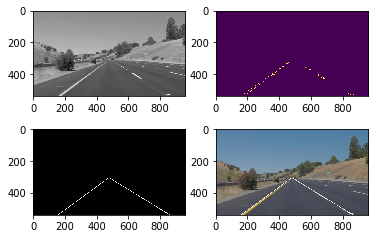

In [68]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission


---

**Finding Lane Lines on the Road**

---

This is the first project for Udacity's Self Driving Car Nano Degree. It was a very challenging experience and also a lot of fun. At every stage of this project- from setup to submission- I learnt something new which made it a very rewarding experience.


### Reflection

### 1. The Pipeline


In the first step of my platform the image was converted to a grayscale representation. To perform this action the helper function provided in the notebook was used. This action changes the colors to a single dimension and makes it easier to identify lines.

The next stage in the pipeline was to perform gaussian blurring in order to reduce noise. After this Cany edge detection was performed to find the contours of the lines.

The fourth step of the pipeline was to determine a region of interest for the lane lines and mask everything else out. After many iterations i choose a polygon mask and used dynamic values as vertices (i.e the vertices are dependent on image dimensions)


The fifth step was to perform the Hough transformation to identify the lanes. After a few iterations I used a set of parameters which one of the instructors used and they worked well.

For improving the draw lines function (to create a single lane line on each side) I got a few ideas from the discussion forums. I describe the procedure as follows

* The Hough Lines contain the pair of points each line is represented by. Using these points the slope and intercept for each line can be calculated. The direction of the slope also tells us which lane line it is ( right or left).

* After collecting the slope and intercepts for all the lines, the next step is to eliminate the outliers. All lines whose slope was more than 1 standard deviation away from the average slope of all the lines were eliminated.

* After eliminating the outliers the average slope and average intercept for the remaining left side lane lines and remaining right side lane lines were calculated. These are now the lines we want.

* The intersection point of the two lane lines calculated above is calculated and lines were drawn from the intersection point to the bottom of the image.


### 2. Shortcomings with this pipeline

There are a few shortcomings with my pipeline the most important one being that the code is a bit too rigid and has been trained to work for the given set of images. It will not work well with a different quality of images because a lot of the parameters have been hard coded.

The line markings are in white, I was unable to fix it show red lines. I believe the code in draw_lines is somehow causing this but I haven't been able to rectify it yet.

For the yellow lines video there is a lot of jitter, I believe this may be because I am being a bit too rigid in eliminating outliers when finding the average of the slopes


### 3. Possible Improvements

Possible improvements are to fix the shortcomings referred to earlier. Also more fine tuning with other images could help the pipeline generalize better. I did not have a chance to work on the optional challenge, the model can be improved further by getting it to work with the challenge video. 

In order to reduce the jitter some smoothing techniques will have to be applied to reduce the impact of line changes between frames.









## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [86]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [Errno 12] Cannot allocate memory

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))